# Natural Language Processing Project

I will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
!conda install nltk --yes
import nltk
from nltk.corpus import stopwords

Solving environment: done

# All requested packages already installed.



In [36]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  stopwords


      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


True

## The Data

In [37]:
yelp = pd.read_csv('yelp.csv')

In [38]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [39]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [40]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [41]:
yelp['text length'] = yelp['text'].apply(len)

# EDA

**Use FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings. Reference the seaborn documentation for hints on this**

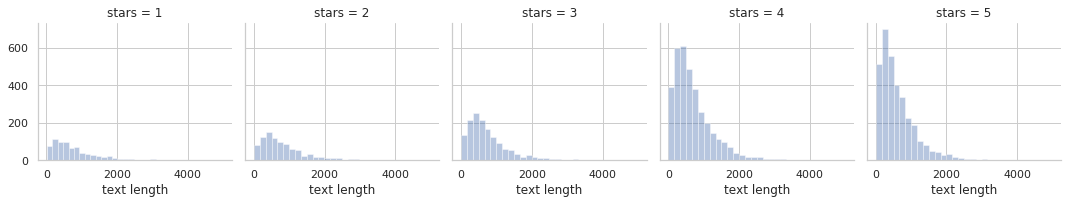

In [42]:
sns.set(style='whitegrid')
g = sns.FacetGrid(col='stars',data=yelp)
g.map(sns.distplot,'text length',kde=False,bins=30)

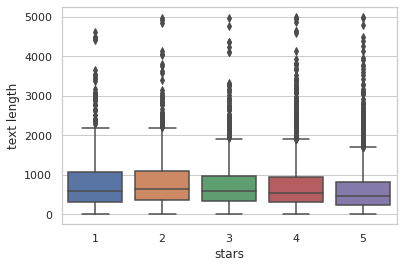

In [43]:
sns.boxplot(data=yelp,x='stars',y='text length')

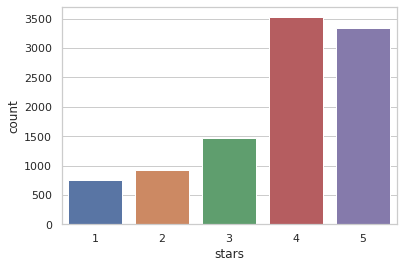

In [44]:
sns.countplot(data=yelp,x='stars')

In [45]:
yelp.groupby('stars').mean()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


**Use the corr() method on that groupby dataframe to produce this dataframe:**

In [46]:
a=yelp.drop('stars',axis=1).corr()
a

,cool,useful,funny,text length
cool,1.000000,0.887102,0.764342,0.241451
useful,0.887102,1.000000,0.723406,0.293975
funny,0.764342,0.723406,1.000000,0.251760
text length,0.241451,0.293975,0.251760,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

(0, 4)

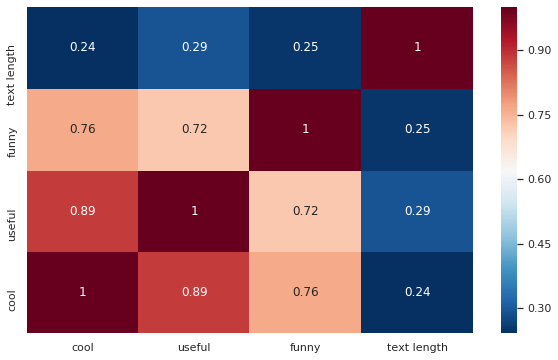

In [47]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(a,annot=True,cmap='RdBu_r')
plt.ylim(0,4)

## NLP Classification Task

Creating a Dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews (because stars 2-4 get a little complicated)

In [48]:
yelp_class = yelp[(yelp['stars']==1) | (yelp['stars']==5)]

In [49]:
X = yelp_class['text']
y = yelp_class['stars']

## Train Test Split

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Creation of Pipeline using CountVectorizer and MultinomialNB classifier - Without Tf Idf

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [53]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('classifier', MultinomialNB()),
])

In [54]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluations

In [55]:
yhat=pipeline.predict(X_test)

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
print(confusion_matrix(y_test,yhat))
print('\n')
print(classification_report(y_test,yhat))

[[155  73]
 [ 15 983]]


              precision    recall  f1-score   support

           1       0.91      0.68      0.78       228
           5       0.93      0.98      0.96       998

   micro avg       0.93      0.93      0.93      1226
   macro avg       0.92      0.83      0.87      1226
weighted avg       0.93      0.93      0.92      1226



## Creation of Pipeline using CountVectorizer and MultinomialNB classifier - With Tf Idf

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer

In [59]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [60]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

In [61]:
yhat=pipeline.predict(X_test)

In [62]:
print(confusion_matrix(y_test,yhat))
print('\n')
print(classification_report(y_test,yhat))

[[  0 228]
 [  0 998]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

   micro avg       0.81      0.81      0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Looks like Tf-Idf actually made things worse.


## Some more trial and error Pipelines

### #1 Using random forests

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(500)),
])

In [82]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [83]:
yhat=pipeline.predict(X_test)

In [84]:
print(confusion_matrix(y_test,yhat))
print('\n')
print(classification_report(y_test,yhat))

[[ 43 185]
 [  1 997]]


              precision    recall  f1-score   support

           1       0.98      0.19      0.32       228
           5       0.84      1.00      0.91       998

   micro avg       0.85      0.85      0.85      1226
   macro avg       0.91      0.59      0.62      1226
weighted avg       0.87      0.85      0.80      1226



Interesting note, false negatives is only 1 whereas false positive is 186 (Note: Negative is 1, positive is 5). Meaning, it has given a lot of 5s where it was actually 1 but where was actually 5, it was very accurate!

### #1 Using K nearest neighbors

In [85]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', KNeighborsClassifier(n_neighbors=10)),
])

In [90]:
pipeline.fit(X_train,y_train)
yhat=pipeline.predict(X_test)

In [91]:
print(confusion_matrix(y_test,yhat))
print('\n')
print(classification_report(y_test,yhat))

[[121 107]
 [ 38 960]]


              precision    recall  f1-score   support

           1       0.76      0.53      0.63       228
           5       0.90      0.96      0.93       998

   micro avg       0.88      0.88      0.88      1226
   macro avg       0.83      0.75      0.78      1226
weighted avg       0.87      0.88      0.87      1226

